<a href="https://colab.research.google.com/github/jayantkp/Forecasting-System---Project-Demand-of-Products-at-a-Retail-Outlet-Based-on-Historical-Data/blob/main/Forecast_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the necessary libraries

In [14]:
pip install --upgrade xlrd

     |████████████████████████████████| 96 kB 2.7 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import itertools
import seaborn as sns

Import the dataset

In [2]:
url = 'https://github.com/jayantkp/Forecasting-System---Project-Demand-of-Products-at-a-Retail-Outlet-Based-on-Historical-Data/blob/main/Dataset/data.xls?raw=true'
df = pd.read_excel(url, parse_dates = ['Order Date'])

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
#Check for missing values
df.isna().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [5]:
#Check the columns present in the dataset
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [6]:
#Check the different types of product categories included
df['Category'].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

Creating dataframes for each product category

In [7]:
#data related to tech sales. 
tech = df.loc[df['Category'] == 'Technology']
tech

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
7,8,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.152,6,0.2,90.7152
11,12,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002033,Technology,Phones,Konftel 250 Conference phone - Charcoal black,911.424,4,0.2,68.3568
19,20,CA-2014-143336,2014-08-27,2014-09-01,Second Class,ZD-21925,Zuschuss Donatelli,Consumer,United States,San Francisco,...,94109,West,TEC-PH-10001949,Technology,Phones,Cisco SPA 501G IP Phone,213.480,3,0.2,16.0110
26,27,CA-2016-121755,2016-01-16,2016-01-20,Second Class,EH-13945,Eric Hoffmann,Consumer,United States,Los Angeles,...,90049,West,TEC-AC-10003027,Technology,Accessories,Imation 8GB Mini TravelDrive USB 2.0 Flash Drive,90.570,3,0.0,11.7741
35,36,CA-2016-117590,2016-12-08,2016-12-10,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080,Central,TEC-PH-10004977,Technology,Phones,GE 30524EE4,1097.544,7,0.2,123.4737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9983,9984,US-2016-157728,2016-09-22,2016-09-28,Standard Class,RC-19960,Ryan Crowe,Consumer,United States,Grand Rapids,...,49505,Central,TEC-PH-10001305,Technology,Phones,Panasonic KX TS208W Corded phone,97.980,2,0.0,27.4344
9986,9987,CA-2016-125794,2016-09-29,2016-10-03,Standard Class,ML-17410,Maris LaWare,Consumer,United States,Los Angeles,...,90008,West,TEC-AC-10003399,Technology,Accessories,Memorex Mini Travel Drive 64 GB USB 2.0 Flash ...,36.240,1,0.0,15.2208
9987,9988,CA-2017-163629,2017-11-17,2017-11-21,Standard Class,RA-19885,Ruben Ausman,Corporate,United States,Athens,...,30605,South,TEC-AC-10001539,Technology,Accessories,Logitech G430 Surround Sound Gaming Headset wi...,79.990,1,0.0,28.7964
9988,9989,CA-2017-163629,2017-11-17,2017-11-21,Standard Class,RA-19885,Ruben Ausman,Corporate,United States,Athens,...,30605,South,TEC-PH-10004006,Technology,Phones,Panasonic KX - TS880B Telephone,206.100,5,0.0,55.6470


In [8]:
#Keeping only the relevant columns in tech 
tech = tech[['Order Date','Sales']]
tech

,Order Date,Sales
7,2014-06-09,907.152
11,2014-06-09,911.424
19,2014-08-27,213.480
26,2016-01-16,90.570
35,2016-12-08,1097.544
...,...,...
9983,2016-09-22,97.980
9986,2016-09-29,36.240
9987,2017-11-17,79.990
9988,2017-11-17,206.100


In [9]:
#Sorting data according to order date
tech = tech.sort_values(by = 'Order Date')
tech

,Order Date,Sales
7478,2014-01-06,755.960
7477,2014-01-06,391.980
593,2014-01-09,31.200
765,2014-01-13,646.740
1913,2014-01-15,149.950
...,...,...
4924,2017-12-25,90.480
2569,2017-12-27,164.388
573,2017-12-28,14.850
1878,2017-12-29,302.376


In [10]:
#tech sales in each date
tech = tech.groupby('Order Date')['Sales'].sum().reset_index()
tech

,Order Date,Sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


In [11]:
tech.set_index('Order Date', inplace = True)

In [12]:
tech

,Sales
Order Date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


In [13]:
#Resampling the data into means of monthly sales
tech_y = tech['Sales'].resample('MS').mean()
tech_y

Order Date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
2017-01-01    1195.218071
2017-02-01     430.501714
2

Creating a similar dataframe for office supplies

In [14]:
#data related to office supplies sales. 
off_sup = df.loc[df['Category'] == 'Office Supplies']
off_sup

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2,0.2,2.5164
6,7,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.280,4,0.0,1.9656
8,9,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.504,3,0.2,5.7825
9,10,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,114.900,5,0.0,34.4700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9982,9983,US-2016-157728,2016-09-22,2016-09-28,Standard Class,RC-19960,Ryan Crowe,Consumer,United States,Grand Rapids,...,49505,Central,OFF-PA-10002195,Office Supplies,Paper,"RSVP Cards & Envelopes, Blank White, 8-1/2"" X ...",35.560,7,0.0,16.7132
9984,9985,CA-2015-100251,2015-05-17,2015-05-23,Standard Class,DV-13465,Dianna Vittorini,Consumer,United States,Long Beach,...,11561,East,OFF-LA-10003766,Office Supplies,Labels,Self-Adhesive Removable Labels,31.500,10,0.0,15.1200
9985,9986,CA-2015-100251,2015-05-17,2015-05-23,Standard Class,DV-13465,Dianna Vittorini,Consumer,United States,Long Beach,...,11561,East,OFF-SU-10000898,Office Supplies,Supplies,Acme Hot Forged Carbon Steel Scissors with Nic...,55.600,4,0.0,16.1240
9992,9993,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.600,4,0.0,13.3200


In [15]:
#Keeping only the relevant columns in off_sup
off_sup = off_sup[['Order Date','Sales']]
off_sup

,Order Date,Sales
2,2016-06-12,14.620
4,2015-10-11,22.368
6,2014-06-09,7.280
8,2014-06-09,18.504
9,2014-06-09,114.900
...,...,...
9982,2016-09-22,35.560
9984,2015-05-17,31.500
9985,2015-05-17,55.600
9992,2017-02-26,29.600


In [16]:
#Sorting data according to order date
off_sup = off_sup.sort_values(by = 'Order Date')
off_sup

,Order Date,Sales
7980,2014-01-03,16.448
740,2014-01-04,272.736
739,2014-01-04,11.784
741,2014-01-04,3.540
1759,2014-01-05,19.536
...,...,...
5091,2017-12-30,3.024
1297,2017-12-30,20.720
908,2017-12-30,52.776
1296,2017-12-30,13.904


In [17]:
#office supplies sales in each date
off_sup = off_sup.groupby('Order Date')['Sales'].sum().reset_index()
off_sup

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,685.340
4,2014-01-07,10.430
...,...,...
1143,2017-12-26,814.594
1144,2017-12-27,13.248
1145,2017-12-28,1091.244
1146,2017-12-29,282.440


In [18]:
off_sup.set_index('Order Date', inplace = True)

In [19]:
#Resampling the data into means of monthly sales
office_y = off_sup['Sales'].resample('MS').mean()
office_y

Order Date
2014-01-01     285.357647
2014-02-01      63.042588
2014-03-01     391.176318
2014-04-01     464.794750
2014-05-01     324.346545
2014-06-01     588.774409
2014-07-01     756.060400
2014-08-01     541.879143
2014-09-01    1015.677704
2014-10-01     267.078815
2014-11-01     959.372714
2014-12-01     692.556231
2015-01-01     129.198571
2015-02-01     335.504188
2015-03-01     690.545522
2015-04-01     502.342320
2015-05-01     364.549440
2015-06-01     560.407737
2015-07-01     205.214739
2015-08-01     558.814667
2015-09-01     772.230680
2015-10-01     361.392083
2015-11-01     757.790357
2015-12-01     540.055800
2016-01-01     331.230125
2016-02-01     357.597368
2016-03-01     693.877240
2016-04-01     462.932478
2016-05-01     449.489724
2016-06-01     436.072400
2016-07-01     587.474727
2016-08-01     344.605385
2016-09-01     830.847786
2016-10-01     678.408083
2016-11-01     787.972231
2016-12-01    1357.055929
2017-01-01     967.013136
2017-02-01     389.882737
2

Creating a similar dataframe for furniture

In [20]:
#data related to furniture sales. 
furniture = df.loc[df['Category'] == 'Furniture']
furniture

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9962,9963,CA-2015-168088,2015-03-19,2015-03-22,First Class,CM-12655,Corinna Mitchell,Home Office,United States,Houston,...,77041,Central,FUR-BO-10004218,Furniture,Bookcases,Bush Heritage Pine Collection 5-Shelf Bookcase...,383.4656,4,0.32,-67.6704
9964,9965,CA-2016-146374,2016-12-05,2016-12-10,Second Class,HE-14800,Harold Engle,Corporate,United States,Newark,...,19711,East,FUR-FU-10002671,Furniture,Furnishings,Electrix 20W Halogen Replacement Bulb for Zoom...,13.4000,1,0.00,6.4320
9980,9981,US-2015-151435,2015-09-06,2015-09-09,Second Class,SW-20455,Shaun Weien,Consumer,United States,Lafayette,...,70506,South,FUR-TA-10001039,Furniture,Tables,KI Adjustable-Height Table,85.9800,1,0.00,22.3548
9989,9990,CA-2014-110422,2014-01-21,2014-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028


In [21]:
#Keeping only the relevant columns in furniture
furniture = furniture[['Order Date','Sales']]
furniture

,Order Date,Sales
0,2016-11-08,261.9600
1,2016-11-08,731.9400
3,2015-10-11,957.5775
5,2014-06-09,48.8600
10,2014-06-09,1706.1840
...,...,...
9962,2015-03-19,383.4656
9964,2016-12-05,13.4000
9980,2015-09-06,85.9800
9989,2014-01-21,25.2480


In [22]:
#Sorting data according to order date
furniture = furniture.sort_values(by = 'Order Date')

In [23]:
#furniture sales in each date
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [24]:
furniture.set_index('Order Date', inplace = True)

In [25]:
#Resampling the data into means of monthly sales
furniture_y = furniture['Sales'].resample('MS').mean()
furniture_y

Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049188
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
2016-01-01     508.182867
2016-02-01     356.868273
2016-03-01     609.575810
2016-04-01     695.373158
2016-05-01     687.265227
2016-06-01     816.910750
2016-07-01     768.736412
2016-08-01     734.307782
2016-09-01    1135.953371
2016-10-01     624.872474
2016-11-01    1271.345152
2016-12-01    1410.719808
2017-01-01     397.602133
2017-02-01     528.179800
2

Plotting the sales data for each categories

Text(0, 0.5, 'Sales')

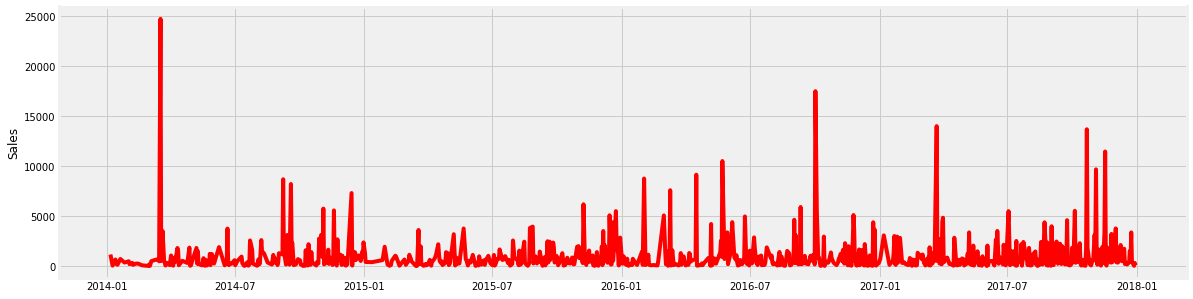

In [26]:
plt.figure(figsize = (18,5))
plt.plot(tech, c = 'r')
plt.ylabel('Sales')

Text(0, 0.5, 'Sales')

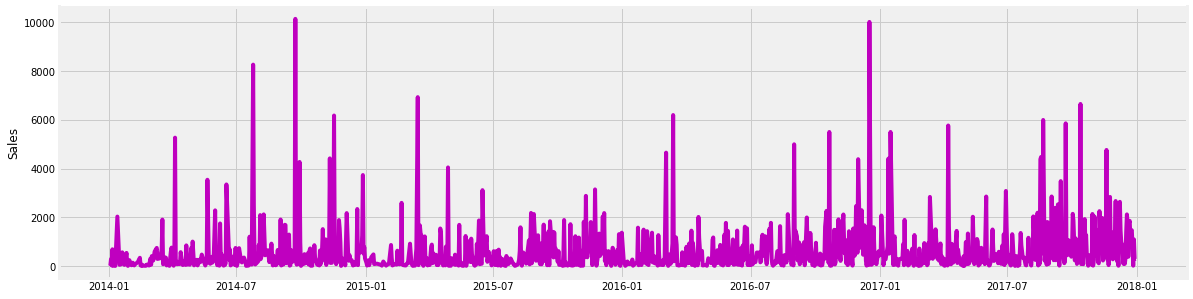

In [27]:
plt.figure(figsize = (18,5))
plt.plot(off_sup , c= 'm')
plt.ylabel('Sales')

Text(0, 0.5, 'Sales')

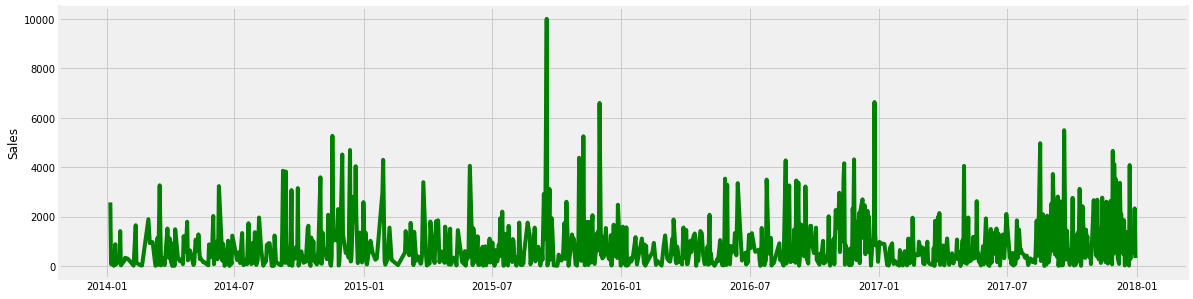

In [28]:
plt.figure(figsize = (18,5))
plt.plot(furniture, c = 'g')
plt.ylabel('Sales')

Plotting the mean sales data for each categories

Text(0.5, 1.0, 'TECHNOLOGY SALES')

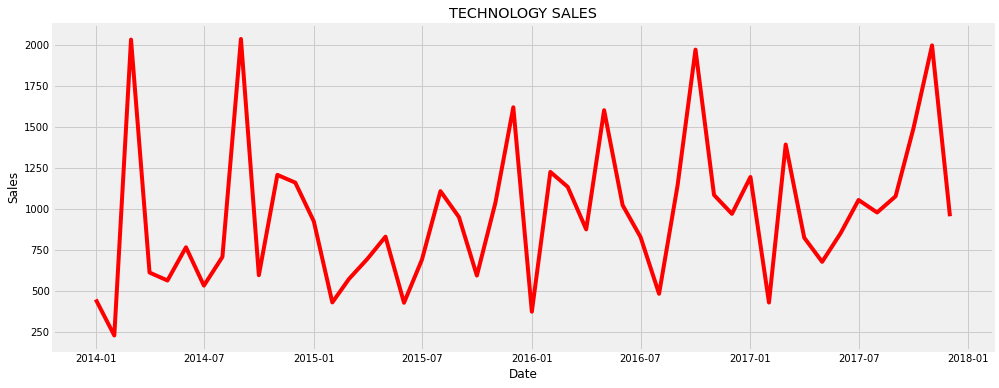

In [29]:
plt.figure(figsize = (15,6))
plt.plot(tech_y, c = 'r')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('TECHNOLOGY SALES')

Text(0.5, 1.0, 'OFFICE SUPPLY SALES')

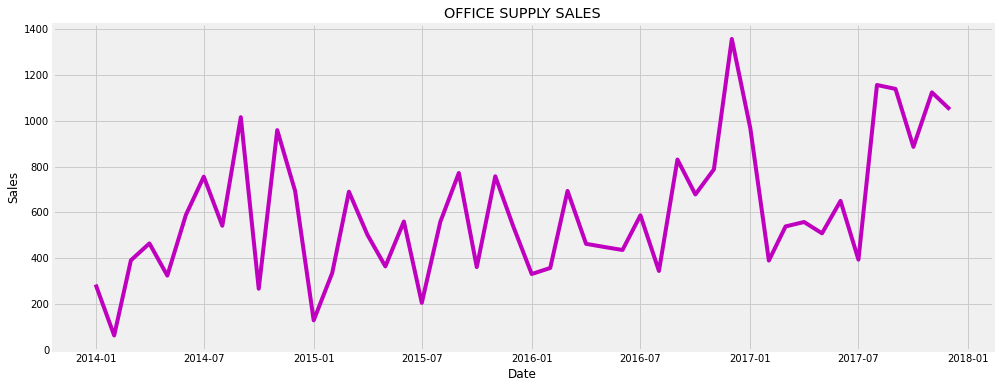

In [30]:
plt.figure(figsize = (15,6))
plt.plot(office_y, c = 'm')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('OFFICE SUPPLY SALES')

Text(0.5, 1.0, 'FURNITURE SALES')

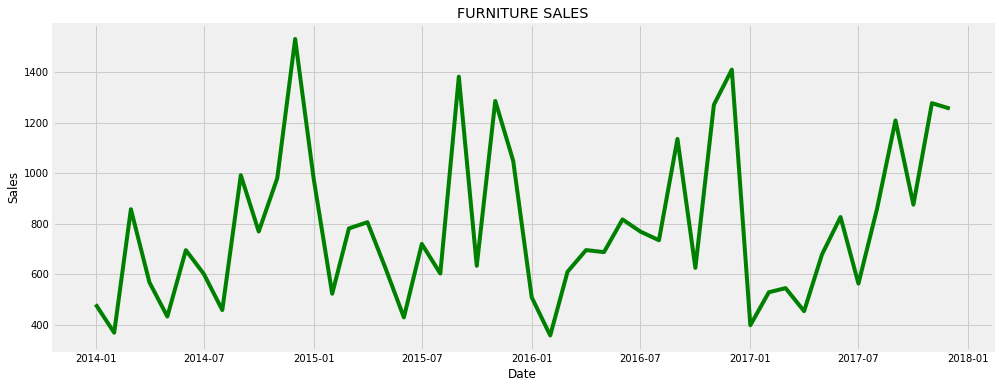

In [31]:
plt.figure(figsize = (15,6))
plt.plot(furniture_y, c = 'g')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('FURNITURE SALES')